# Pulsations

In [12]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_pulsation, evaluate_pulsations
from spice.spectrum import simulate_observed_flux
import jax.numpy as jnp
import numpy as np
from transformer_payne import TransformerPayne
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

import jax

Let's use the more serious spectrum emulator, our ```TransformerPayne```.

It produces realistic spectra for some range of parameters, just beware of the speed - it can get rather slow on CPUs so make sure to get some GPUs for this purpose!

In [13]:
tp = TransformerPayne.download()

The API is in the functional paradigm - you pass a "model" mesh, and the function returns a modified version of the mesh. However, the original passed mesh still remains if you choose not to overwrite these variables.

The pulsations are represented as arrays of amplitude (percentage of the radius), which is calculated as a function of time. The user passes in parameters for the Fourier series representing this function:

$A = D + \sum_{n=1}^N cos(\frac{n}{P}t_n-\phi_n)$

In [14]:
m = IcosphereModel.construct(1000, 1., 1.,
                             tp.to_parameters(dict(logteff=np.log10(8340), logg=4.3)), tp.stellar_parameter_names)
m = add_pulsation(m, 0, 0, 1., jnp.array([[0.25, 0.]]), pulsation_angles=jnp.array([0.]))

/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/transformer_payne/transformer_payne.py:576: UserWarning: Possible exceeding parameter bonds - extrapolating.
  warnings.warn("Possible exceeding parameter bonds - extrapolating.")


As in the case of any modifications, we have to call the ```evaluate``` function to obtain meshes which have the modified parameters.

In [15]:
TIMESTAMPS = jnp.linspace(0., 1., 30)
mps = [evaluate_pulsations(m, t) for t in tqdm(TIMESTAMPS)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.02it/s]


Let's update the temperature, assuming the luminosity is constant and:

$L=4\pi R^2 \sigma T^4$

so:

$T\propto R^{-\frac{1}{2}}$

In [16]:
# For constant luminosity L=4πR²σT⁴, if R changes, T must change to maintain L
# This means T ∝ R^(-1/2)

# Get the original radius and temperature
original_radius = 1.0  # The radius we used when constructing the model
original_teff = 8340   # The effective temperature we used

# Calculate the new temperatures for each pulsating mesh
for i, mp in enumerate(mps):
    # Get the current radius (which varies due to pulsation)
    current_radius = mp.radii.mean()  # Taking mean radius as representative
    
    # Calculate the new temperature using T ∝ R^(-1/2) relation
    # T_new = T_original * (R_original/R_new)^(1/2)
    scaling_factor = (original_radius / current_radius) ** 0.5
    new_teff = original_teff * scaling_factor
    
    # Update the temperature parameter in the mesh
    # We need to update the log(Teff) parameter since that's what the model uses
    new_logteff = np.log10(new_teff)
    # Find the index of logteff in the parameter names
    logteff_idx = tp.stellar_parameter_names.index('logteff')
    
    # Update the parameters (create a copy to avoid modifying the original)
    new_params = mp.parameters.at[:, logteff_idx].set(new_logteff)
    
    # Replace the mesh with updated temperature
    mps[i] = mp._replace(parameters=new_params)

print(f"Temperature scaling applied to maintain constant luminosity (T ∝ R^(-1/2))")


Temperature scaling applied to maintain constant luminosity (T ∝ R^(-1/2))


/home/100/mj8805/scr/mj8805/miniconda3/envs/astro/lib/python3.12/site-packages/spice/plots/plot_mesh.py:297: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout()


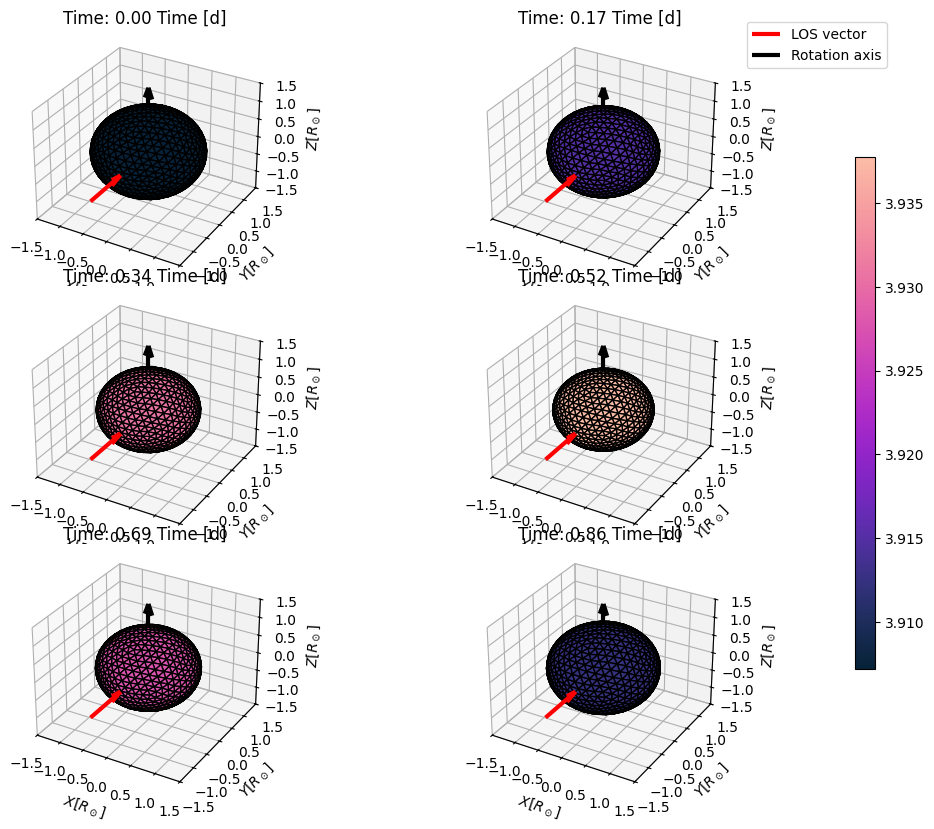

In [17]:
from spice.plots import plot_3D_sequence

fig, ax, _ = plot_3D_sequence(mps[::5], property=0, timestamps=TIMESTAMPS[::5], timestamp_label='Time [d]')

## Spectrum emulation

Let's calculate the spectrum in a broad range of wavelengths.

In [18]:
vws = jnp.linspace(4800, 6800, 1000)
specs = [simulate_observed_flux(tp.intensity, mp0, jnp.log10(vws)) for mp0 in tqdm(mps)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:38<00:00,  3.30s/it]


We can inspect the spectrum changing over time.

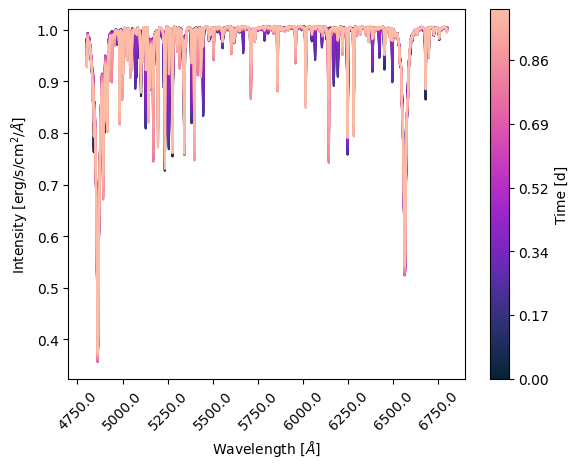

In [28]:
import cmasher as cmr
import matplotlib.pyplot as plt

# Set the matplotlib style to white background
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'



# Create a colormap based on the timestamps
cmap = cmr.bubblegum
norm = plt.Normalize(TIMESTAMPS.min(), TIMESTAMPS.max())
fig, ax = plt.subplots()

from scipy.ndimage import gaussian_filter1d

# Define the smoothing sigma parameter
sigma = 1.0  # Adjust this value to control the amount of smoothing
smoothed_specs = [gaussian_filter1d(spec[:, 0]/spec[:, 1], sigma) for spec in specs]

# Plot the spectra with colors corresponding to timestamps
for spec, timestamp in zip(smoothed_specs, TIMESTAMPS):
    ax.plot(vws, spec, color=cmap(norm(timestamp)))

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This line is necessary for the colorbar to work correctly
cbar = plt.colorbar(sm, ax=ax, ticks=TIMESTAMPS[::5])
cbar.set_label('Time [d]')

# Set the colorbar tick labels to the timestamp values
cbar.set_ticklabels([f'{t:.2f}' for t in TIMESTAMPS[::5]])

plt.gca().set_xlabel(r'Wavelength [$\AA$]')
plt.gca().set_ylabel(r'Intensity [erg/s/cm$^2$/$\AA$]')
plt.gca().tick_params(axis='x', rotation=45)
# Set the x-axis limits with full numbers instead of scientific notation
# Format the x-axis tick labels to show full numbers
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))


plt.show()

In [20]:
from spice.spectrum import AB_passband_luminosity
from spice.spectrum.filter import JohnsonCousinsV, JohnsonCousinsB

johnsonV = JohnsonCousinsV()
johnsonB = JohnsonCousinsB()
lums_johnson_v = [AB_passband_luminosity(johnsonV, vws, s[:, 0]) for s in specs]
lums_johnson_b = [AB_passband_luminosity(johnsonB, vws, s[:, 0]) for s in specs]

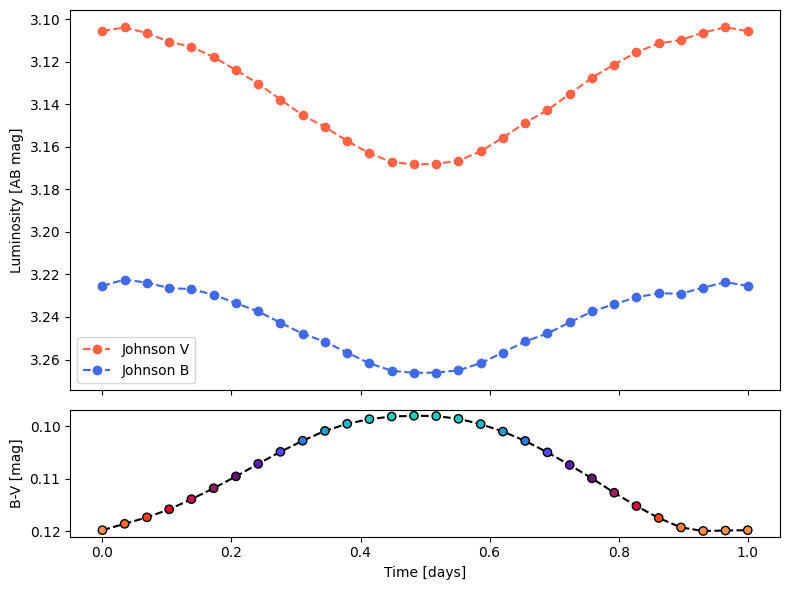

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot magnitudes in the top subplot
ax1.plot(TIMESTAMPS, lums_johnson_v, color='tomato', label='Johnson V', marker='o', linestyle='--')
ax1.plot(TIMESTAMPS, lums_johnson_b, color='royalblue', label='Johnson B', marker='o', linestyle='--')
ax1.invert_yaxis()
ax1.legend()
ax1.set_ylabel('Luminosity [AB mag]')

# Plot color (B-V) in the bottom subplot
color = np.array(lums_johnson_b) - np.array(lums_johnson_v)
ax2.plot(TIMESTAMPS, color, color='black', linestyle='--', zorder=0)
ax2.scatter(TIMESTAMPS, color, c=np.array(lums_johnson_b) - np.array(lums_johnson_v), cmap='cmr.guppy_r', zorder=1, edgecolor='black')
ax2.set_xlabel('Time [days]')
ax2.set_ylabel('B-V [mag]')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

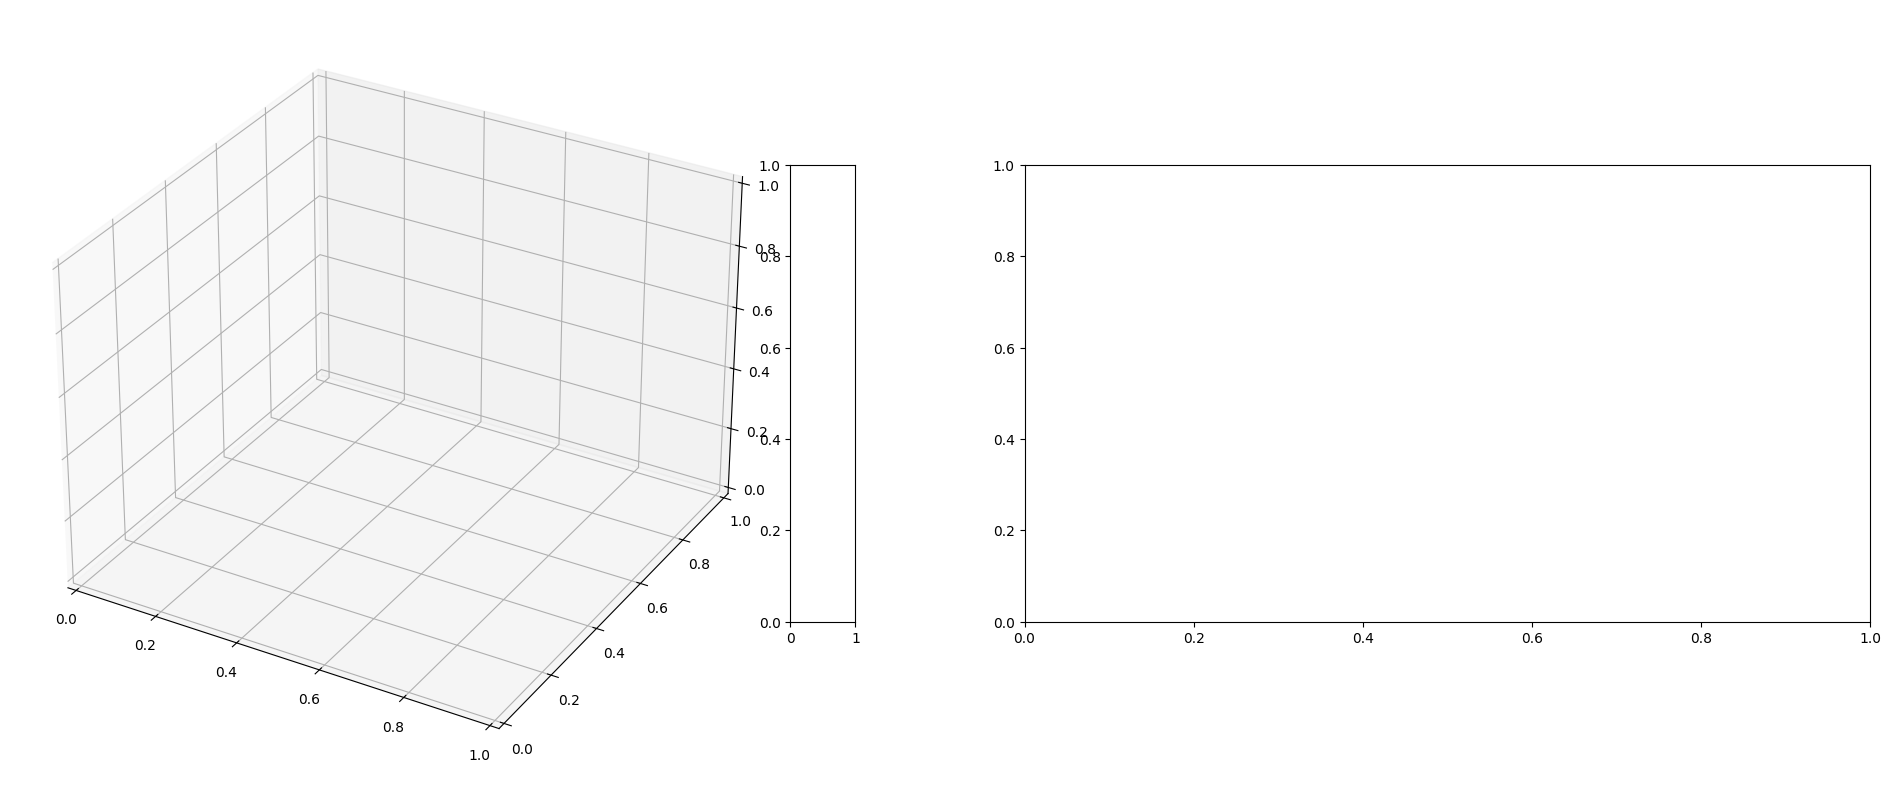

MovieWriter ffmpeg unavailable; using Pillow instead.


<Figure size 640x480 with 0 Axes>

In [54]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import art3d
from typing import Any, Dict, List, Optional, Tuple, Union
import numpy as np
from spice.models import MeshModel
from jax.typing import ArrayLike
import cmasher as cmr
from celluloid import Camera

PLOT_MODES = ['MESH', 'POINTS']
COLORMAP_PROPERTIES = ['mus', 'los_velocities', 'cast_areas', 'log_gs']
DEFAULT_PROPERTY = 'mus'

DEFAULT_PLOT_PROPERTY_LABELS = {
    'mus': r'$\mu$',
    'los_velocities': 'LOS velocity [km/s]',
    'cast_areas': 'cast area [km$^2$]',
    'log_gs': 'log g'
}

DEFAULT_PROPERTY_CMAPS = {
    'los_velocities': 'cmr.redshift_r',
}

DEFAULT_CMAP = 'cmr.bubblegum'

# Create a figure first to ensure it exists before creating the camera
fig = plt.figure(figsize=(24, 10))
spec = fig.add_gridspec(10, 24)
plot_ax = fig.add_subplot(spec[:, :10], projection='3d')
cax = fig.add_subplot(spec[2:8, 10])
spectrum_ax = fig.add_subplot(spec[2:8, 13:])

# Make sure the figure is displayed at least once before creating the camera
plt.draw()
plt.pause(0.1)  # Small pause to ensure the figure is rendered

# Create camera after the figure is properly initialized
camera = Camera(fig)

cmap = 'cmr.bubblegum'  # Set a default cmap

to_be_mapped = np.concatenate([np.power(10, m.parameters[:, 0]) for m in mps])
axes_lim = 1.5*np.max(np.array([np.max(m.radii) for m in mps]))
plot_ax.set_xlim3d(-axes_lim, axes_lim)
plot_ax.set_ylim3d(-axes_lim, axes_lim)
plot_ax.set_zlim3d(-axes_lim, axes_lim)
plot_ax.set_xlabel('$X [R_\\odot]$', fontsize=14)
plot_ax.set_ylabel('$Y [R_\\odot]$', fontsize=14)
plot_ax.set_zlabel('$Z [R_\\odot]$', fontsize=14)

mode = 'MESH'

norm = mpl.colors.Normalize(vmin=to_be_mapped.min(), vmax=to_be_mapped.max())
mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.tight_layout()

for i, (mesh, s) in enumerate(zip(mps, smoothed_specs)):
    # Clear previous collections to avoid overlapping meshes
    plot_ax.set_xlim3d(-axes_lim, axes_lim)
    plot_ax.set_ylim3d(-axes_lim, axes_lim)
    plot_ax.set_zlim3d(-axes_lim, axes_lim)
    plot_ax.set_xlabel('$X [R_\\odot]$', fontsize=14)
    plot_ax.set_ylabel('$Y [R_\\odot]$', fontsize=14)
    plot_ax.set_zlabel('$Z [R_\\odot]$', fontsize=14)

    
    # Get effective temperature for coloring
    mesh_temps = np.power(10, mesh.parameters[:, 0])
    norm = mpl.colors.Normalize(vmin=to_be_mapped.min(), vmax=to_be_mapped.max())
    
    # Plot the mesh
    vs2 = mesh.mesh_elements-mesh.center
    face_colors = mpl.colormaps[cmap](norm(mesh_temps))
    p = art3d.Poly3DCollection(vs2, facecolors=face_colors, edgecolor="black", zorder=0)
    plot_ax.add_collection(p)
    
    # Add timestamp to the plot
    if TIMESTAMPS is not None:
        spectrum_ax.text(0.4, 1.1, f"Time: {TIMESTAMPS[i]:.2f} d",
                        fontsize=24,
                        transform=spectrum_ax.transAxes)
    
    # Add colorbar
    cbar = fig.colorbar(mappable, shrink=0.45, pad=0.125, cax=cax)
    cbar.set_label('$T_{eff}$ [K]', fontsize=12)
    
    # Plot spectrum
    spectrum_ax.plot(vws, s, color='black')
    spectrum_ax.set_ylabel('intensity [erg/s/cm$^2$]', fontsize=14)
    spectrum_ax.set_xlabel('wavelength [$\\AA$]', fontsize=14)
    
    # Make sure the figure is properly drawn before snapping
    #fig.canvas.draw()
    camera.snap()
    
# Create animation after all frames are captured
animation = camera.animate()
animation.save('pulsation.gif')

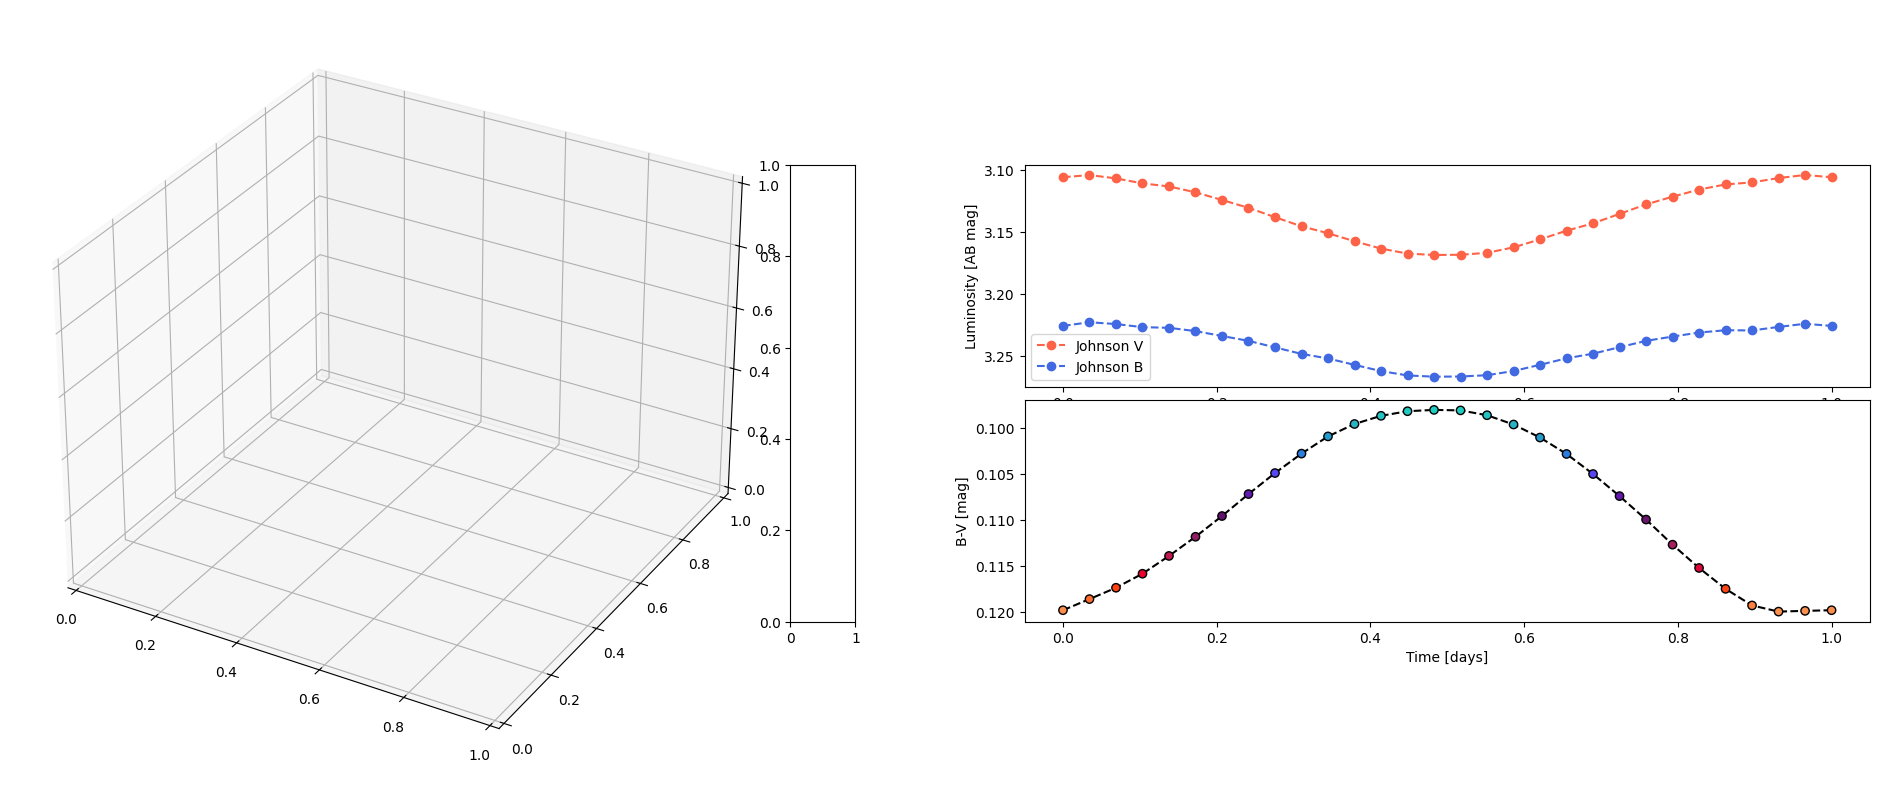

MovieWriter ffmpeg unavailable; using Pillow instead.


<Figure size 640x480 with 0 Axes>

In [68]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import art3d
from typing import Any, Dict, List, Optional, Tuple, Union
import numpy as np
from spice.models import MeshModel
from jax.typing import ArrayLike
import cmasher as cmr
from celluloid import Camera

PLOT_MODES = ['MESH', 'POINTS']
COLORMAP_PROPERTIES = ['mus', 'los_velocities', 'cast_areas', 'log_gs']
DEFAULT_PROPERTY = 'mus'

DEFAULT_PLOT_PROPERTY_LABELS = {
    'mus': r'$\mu$',
    'los_velocities': 'LOS velocity [km/s]',
    'cast_areas': 'cast area [km$^2$]',
    'log_gs': 'log g'
}

DEFAULT_PROPERTY_CMAPS = {
    'los_velocities': 'cmr.redshift_r',
}

DEFAULT_CMAP = 'cmr.bubblegum'

# Create a figure first to ensure it exists before creating the camera
fig = plt.figure(figsize=(24, 10))
spec = fig.add_gridspec(10, 24)
plot_ax = fig.add_subplot(spec[:, :10], projection='3d')
cax = fig.add_subplot(spec[2:8, 10])
ax1 = fig.add_subplot(spec[2:5, 13:])
ax2 = fig.add_subplot(spec[5:8, 13:])

ax1.plot(TIMESTAMPS, lums_johnson_v, color='tomato', label='Johnson V', marker='o', linestyle='--', zorder=1)
ax1.plot(TIMESTAMPS, lums_johnson_b, color='royalblue', label='Johnson B', marker='o', linestyle='--', zorder=1)
ax1.invert_yaxis()
ax1.legend()
ax1.set_ylabel('Luminosity [AB mag]')

# Plot color (B-V) in the bottom subplot
color = np.array(lums_johnson_b) - np.array(lums_johnson_v)
ax2.plot(TIMESTAMPS, color, color='black', linestyle='--', zorder=0)
ax2.scatter(TIMESTAMPS, color, c=np.array(lums_johnson_b) - np.array(lums_johnson_v), cmap='cmr.guppy_r', zorder=1, edgecolor='black')
ax2.set_xlabel('Time [days]')
ax2.set_ylabel('B-V [mag]')
ax2.invert_yaxis()

# Make sure the figure is displayed at least once before creating the camera
plt.draw()
plt.pause(0.1)  # Small pause to ensure the figure is rendered

# Create camera after the figure is properly initialized
camera = Camera(fig)

cmap = 'cmr.bubblegum'  # Set a default cmap

to_be_mapped = np.concatenate([np.power(10, m.parameters[:, 0]) for m in mps])
axes_lim = 1.5*np.max(np.array([np.max(m.radii) for m in mps]))
plot_ax.set_xlim3d(-axes_lim, axes_lim)
plot_ax.set_ylim3d(-axes_lim, axes_lim)
plot_ax.set_zlim3d(-axes_lim, axes_lim)
plot_ax.set_xlabel('$X [R_\\odot]$', fontsize=14)
plot_ax.set_ylabel('$Y [R_\\odot]$', fontsize=14)
plot_ax.set_zlabel('$Z [R_\\odot]$', fontsize=14)

mode = 'MESH'

norm = mpl.colors.Normalize(vmin=to_be_mapped.min(), vmax=to_be_mapped.max())
mappable = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.tight_layout()

for i, (mesh, lv, lb) in enumerate(zip(mps, lums_johnson_v, lums_johnson_b)):
    # Clear previous collections to avoid overlapping meshes
    plot_ax.set_xlim3d(-axes_lim, axes_lim)
    plot_ax.set_ylim3d(-axes_lim, axes_lim)
    plot_ax.set_zlim3d(-axes_lim, axes_lim)
    plot_ax.set_xlabel('$X [R_\\odot]$', fontsize=14)
    plot_ax.set_ylabel('$Y [R_\\odot]$', fontsize=14)
    plot_ax.set_zlabel('$Z [R_\\odot]$', fontsize=14)

    
    # Get effective temperature for coloring
    mesh_temps = np.power(10, mesh.parameters[:, 0])
    norm = mpl.colors.Normalize(vmin=to_be_mapped.min(), vmax=to_be_mapped.max())
    
    # Plot the mesh
    vs2 = mesh.mesh_elements-mesh.center
    face_colors = mpl.colormaps[cmap](norm(mesh_temps))
    p = art3d.Poly3DCollection(vs2, facecolors=face_colors, edgecolor="black", zorder=0)
    plot_ax.add_collection(p)
    
    # Add timestamp to the plot
    if TIMESTAMPS is not None:
        spectrum_ax.text(0.4, 1.1, f"Time: {TIMESTAMPS[i]:.2f} d",
                        fontsize=24,
                        transform=spectrum_ax.transAxes)
    
    # Add colorbar
    cbar = fig.colorbar(mappable, shrink=0.45, pad=0.125, cax=cax)
    cbar.set_label('$T_{eff}$ [K]', fontsize=12)
    
    ax1.plot(TIMESTAMPS, lums_johnson_v, color='tomato', label='Johnson V', marker='o', linestyle='--', zorder=1)
    ax1.plot(TIMESTAMPS, lums_johnson_b, color='royalblue', label='Johnson B', marker='o', linestyle='--', zorder=1)
    ax1.invert_yaxis()
    ax1.set_ylabel('Luminosity [AB mag]')

    # Plot color (B-V) in the bottom subplot
    ax2.plot(TIMESTAMPS, color, color='black', linestyle='--', zorder=0)
    ax2.scatter(TIMESTAMPS, color, c=color, cmap='cmr.guppy_r', zorder=1, edgecolor='black')
    ax2.set_xlabel('Time [days]')
    ax2.set_ylabel('B-V [mag]')
    ax2.invert_yaxis()
    
    ax1.scatter(TIMESTAMPS[i], lv, color='black', marker='o', zorder=3, s=50)
    ax1.scatter(TIMESTAMPS[i], lb, color='black', marker='o', zorder=3, s=50)
    ax2.scatter(TIMESTAMPS[i], lb-lv, color='black', marker='o', zorder=3, s=50)
    
    # Make sure the figure is properly drawn before snapping
    #fig.canvas.draw()
    camera.snap()
    
# Create animation after all frames are captured
animation = camera.animate()
animation.save('pulsation_LUMINOSITIES.gif')